<a href="https://colab.research.google.com/github/Veeraraju-E/Mech-Interp/blob/main/Mech_Interp_imagenet_vit_prisma.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Vit-Prisma Demo

## Setup

In [1]:
!https://github.com/Prisma-Multimodal/ViT-Prisma.git

/bin/bash: line 1: https://github.com/Prisma-Multimodal/ViT-Prisma.git: No such file or directory


In [2]:
!git clone https://github.com/Prisma-Multimodal/ViT-Prisma.git

fatal: destination path 'ViT-Prisma' already exists and is not an empty directory.


In [3]:
!cd ViT-Prisma && pip install -e .

Obtaining file:///content/ViT-Prisma
  Preparing metadata (setup.py) ... done
  Attempting uninstall: vit-prisma
    Found existing installation: vit-prisma 2.0.0
    Uninstalling vit-prisma-2.0.0:
      Successfully uninstalled vit-prisma-2.0.0
  Running setup.py develop for vit-prisma


## What are we targetting
- We'll look at residual connection after mlp after layer 10 only
- not after layer 11 because of additional contrastive loss - verify with `autointerp` scores
- ensure to look at the files at [Vit-Prisma CLIP](https://huggingface.co/Prisma-Multimodal/sparse-autoencoder-clip-b-32-sae-vanilla-x64-layer-1-hook_resid_post-l1-0.0001)

In [4]:
repo_id = "Prisma-Multimodal/sparse-autoencoder-clip-b-32-sae-vanilla-x64-layer-1-hook_resid_post-l1-0.0001"
weights_file = "n_images_2600058.pt"  # changed from "weights.pt" to "n_images_2600058.pt"
config_file = "config.json"

# load the HF API
from huggingface_hub import hf_hub_download
weights_path = hf_hub_download(repo_id=repo_id, filename=weights_file)
config_path = hf_hub_download(repo_id=repo_id, filename=config_file)

/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


### **Ensure to restart space and run all again**
- otherwise you'll end up with `ModuleNotFoundError`

In [5]:
from vit_prisma.sae import SparseAutoencoder

sae = SparseAutoencoder.load_from_pretrained(weights_path=weights_path) # ignore config_path since it already downloads when we loaded the weights

### Sanity Tests

In [6]:
sae
# you should see
#
#StandardSparseAutoencoder(
#  (hook_sae_in): HookPoint()
#  (hook_hidden_pre): HookPoint()
#  (hook_hidden_post): HookPoint()
#  (hook_sae_out): HookPoint()
#  (activation_fn): ReLU()
#)
# The hooking will ensure that we can actually grab activations from the latent

StandardSparseAutoencoder(
  (hook_sae_in): HookPoint()
  (hook_hidden_pre): HookPoint()
  (hook_hidden_post): HookPoint()
  (hook_sae_out): HookPoint()
  (activation_fn): ReLU()
)

In [7]:
sae.cfg
# you'll see a lot of things, but make sure you at least see
# model_name='open-clip:laion/CLIP-ViT-B-32-DataComp.XL-s13B-b90K'

VisionModelSAERunnerConfig(model_class_name='HookedViT', model_name='open-clip:laion/CLIP-ViT-B-32-DataComp.XL-s13B-b90K', vit_model_cfg=None, model_path=None, hook_point_layer=1, layer_subtype='hook_resid_post', hook_point_head_index=None, context_size=50, use_cached_activations=False, use_patches_only=False, cached_activations_path='activations/_network_scratch_s_sonia.joseph_datasets_kaggle_datasets/open-clip:laion_CLIP-ViT-B-32-DataComp.XL-s13B-b90K/blocks.9.hook_mlp_out', image_size=224, architecture='standard', b_dec_init_method='geometric_median', expansion_factor=64, from_pretrained_path=None, is_transcoder=False, transcoder_with_skip_connection=True, out_hook_point_layer=9, layer_out_subtype='hook_mlp_out', d_out=768, _device='cuda', seed=42, _dtype='float32', d_in=768, activation_fn_str='relu', activation_fn_kwargs={}, cls_token_only=False, max_grad_norm=1.0, initialization_method='encoder_transpose_decoder', normalize_activations=None, n_batches_in_buffer=20, store_batch_siz

### Load Model
- load the hooked model
- while instantiating the model, pass the `model_name` that we can get from `sae.cfg`

In [8]:
from vit_prisma.models.model_loader import load_hooked_model

model_name = sae.cfg.model_name
model = load_hooked_model(model_name)
model   # ensure that you see PatchEmbedding() layer with output_channels = 768

HookedViT(
  (embed): PatchEmbedding(
    (proj): Conv2d(3, 768, kernel_size=(32, 32), stride=(32, 32))
  )
  (hook_embed): HookPoint()
  (pos_embed): PosEmbedding()
  (hook_pos_embed): HookPoint()
  (hook_full_embed): HookPoint()
  (ln_pre): LayerNorm(
    (hook_scale): HookPoint()
    (hook_normalized): HookPoint()
  )
  (hook_ln_pre): HookPoint()
  (blocks): ModuleList(
    (0-11): 12 x TransformerBlock(
      (ln1): LayerNorm(
        (hook_scale): HookPoint()
        (hook_normalized): HookPoint()
      )
      (ln2): LayerNorm(
        (hook_scale): HookPoint()
        (hook_normalized): HookPoint()
      )
      (attn): Attention(
        (hook_k): HookPoint()
        (hook_q): HookPoint()
        (hook_v): HookPoint()
        (hook_z): HookPoint()
        (hook_attn_scores): HookPoint()
        (hook_pattern): HookPoint()
        (hook_result): HookPoint()
      )
      (mlp): MLP(
        (hook_pre): HookPoint()
        (hook_post): HookPoint()
      )
      (hook_attn_in): Ho

- it's good to pause here and understand the layers in the model
- one key thing to note here is that there is no `dictionary` layer and correspondingly no `unembedding` layer

### Load Dataset
* to evaluate the SAE, we're going to use ImageNet dataset
* ensure that we set `shuffle=False` since we need to backtrack the exact indices that we would be interested in
* the way we evaluate the SAE is to load the entire dataset and check for the top 10-20 examples that lead to highest activation in the hidden neurons
    * if the dataset is more diverse and large, then it's easier to interpret the particular feature - ensure that dataset is large
    * if the dataset was only dogs, then we would all features to dogs, which in fact, is not be the case







In [9]:
!pip install -q fsspec==2023.9.2

In [10]:
from datasets import load_dataset

dataset = load_dataset("Tsomaros/Imagenet-1k_validation", download_mode="force_redownload", cache_dir="./cache")
# added the two arguments `download_mode` and `cache_dir` based on the problems I ran into, which involved not being able to determine storage locations
print("Takes about 6 minutes on T4 runtime :/")

Extracting data files:   0%|          | 0/1 [00:00<?, ?it/s]

Generating validation split:   0%|          | 0/50000 [00:00<?, ? examples/s]

Takes about 6 minutes on T4 runtime :/


/usr/local/lib/python3.11/dist-packages/datasets/table.py:1421: FutureWarning:

promote has been superseded by promote_options='default'.



In [11]:
from vit_prisma.transforms import get_clip_val_transforms

val_transform = get_clip_val_transforms()    # transformations based on standard deviation instead of mean

### Sanity Test

In [12]:
type(dataset)   # should yield datasets.dataset_dict.DatasetDict

datasets.dataset_dict.DatasetDict

### Let's now create a dataset class to apply the transformations

In [13]:
import torch

class ImageNetDataset(torch.utils.data.DataLoader):
    def __init__(self, dataset, transform=None):
        self.dataset = dataset
        self.transform = transform

    def __len__(self):
        return len(self.dataset)

    def __getitem__(self, idx):
        item = self.dataset[idx]
        image, label = item["image"], item["label"]
        if self.transform:
            image = self.transform(image).to("cuda" if torch.cuda.is_available() else "cpu")
        # image = image.convert("RGB")  # if the dataset is b&w
        return image, label

In [14]:
val_dataset = ImageNetDataset(dataset["validation"], val_transform)
val_loader = torch.utils.data.DataLoader(val_dataset, batch_size=4, shuffle=False)
image = next(iter(val_loader))[0]   # image only

<ipython-input-15-2605779770>:7: DeprecationWarning:

__array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)



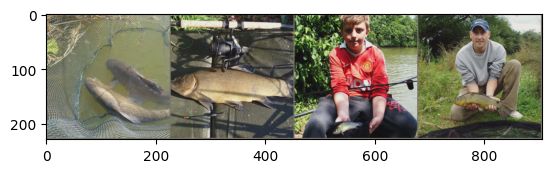

In [15]:
# quick function to plot image data
import matplotlib.pyplot as plt
import torchvision

def imshow(img_tensor, mean, std):
    img = img_tensor.permute(1, 2, 0).cpu().numpy()
    img = std * img + mean  # normalize
    plt.imshow(img)

mean = torch.tensor([0.485, 0.456, 0.406])
std = torch.tensor([0.229, 0.224, 0.225])

grid_img = torchvision.utils.make_grid(image)
imshow(grid_img, mean, std) # should see all fishes since we disabled shuffle



---



### Evaluation Sample

In [16]:
!wget -O parrots.jpeg https://github.com/Prisma-Multimodal/ViT-Prisma/raw/main/src/vit_prisma/sample_images/n01818515_39_typographic.JPEG
# re-labeled the image to parrots.jpeg

--2025-06-16 12:01:22--  https://github.com/Prisma-Multimodal/ViT-Prisma/raw/main/src/vit_prisma/sample_images/n01818515_39_typographic.JPEG
Resolving github.com (github.com)... 140.82.116.4
Connecting to github.com (github.com)|140.82.116.4|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://raw.githubusercontent.com/Prisma-Multimodal/ViT-Prisma/main/src/vit_prisma/sample_images/n01818515_39_typographic.JPEG [following]
--2025-06-16 12:01:22--  https://raw.githubusercontent.com/Prisma-Multimodal/ViT-Prisma/main/src/vit_prisma/sample_images/n01818515_39_typographic.JPEG
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 58383 (57K) [image/jpeg]
Saving to: ‘parrots.jpeg’

parrots.jpeg        100%[===================>]  57.01K  

<ipython-input-15-2605779770>:7: DeprecationWarning:

__array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)



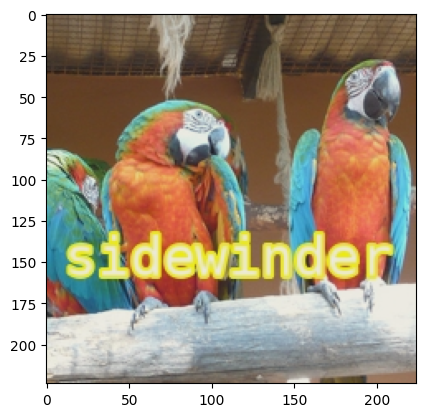

In [17]:
from PIL import Image
from vit_prisma.transforms import get_clip_val_transforms

image = Image.open("parrots.jpeg")
val_transform = get_clip_val_transforms()
image = val_transform(image)
imshow(image, mean, std)

### Cache activations for test image
- we want to feed the eval set image(s) into the model and cache the activations that result from the forward pass
- specifically those of `mlp_10`

In [18]:
# PART 1: What features activate the SAE neurons the most

## Step 1: Feed image into model
model.to("cuda")            # for safety
print(sae.cfg.hook_point)
# for safety, just check the hook point; if it already yields ["blocks.10.hook_mlp_out"], good; else explicitly mention it in the names_filter argument
# for me it yielded => blocks.1.hook_resid_post, so I'm explicitly mentioning the hook point in the names_filter parameter
output, activations_cache = model.run_with_cache(image.unsqueeze(0).to("cuda"), names_filter=["blocks.10.hook_mlp_out"])    # ensure it runs on cuda
activations_cache   # should yield => ActivationCache with keys ['blocks.1.hook_resid_post']

## Step 1.5: Cache activations @ layer 10 mlp out
activations = activations_cache["blocks.10.hook_mlp_out"]   # redundant but useful for later

## Step 2: Feed the cached activations into the SAE
output, feature_activations, *data = sae.encode(activations)
print(f'output.shape: {output.shape}, feature_activations.shape: {feature_activations.shape}')  # 768-dimensional and 50k-ish dimensional (64x expansion factor)
# feature_activations is essentially our dictionary
# you should also take a look at the 2nd dimension => "50" => this essentially is the number of patches in the image
# we have 49 patches, each 16*16 (RGB), and also a prepended [CLS] token, i.e.,
# feature_activations_cls <- feature_activations[0, 0, :]    # first token

## Step 3: Look at which SAE features get maximally activated (top-k)

# to this end, we need to just send in 1 patch => this could be the [CLS] token, or avg of all tokens
# taking the [CLS] token is likely to help look at the global representation
# since we are already looking at mlp_10, safest bet is try and understand the feature_activations of the [CLS] token itself

feature_activations_cls = feature_activations[0, 0, :]
from vit_prisma.utils.tutorial_utils import plot_act_distribution   # to retrieve top-k

top_indices, _ = plot_act_distribution(feature_activations_cls.squeeze(0), n_top=10)    # single dimensional tensor only

blocks.1.hook_resid_post
output.shape: torch.Size([1, 50, 768]), feature_activations.shape: torch.Size([1, 50, 49152])
Top 10 feature indices: [20379, 37638, 25718, 25376, 36926, 19914, 43384, 37918, 37512, 49133]
Top 10 feature values: [0.2690999  0.28346482 0.2841109  0.30148798 0.30767637 0.32326728
 0.349539   0.40335864 0.422297   0.44413763]


- you should be able to see some of the outlier features getting activated for the input image
- but what are these features? we can extract this information by passing in the entire dataset and seeing which image activated what

In [ ]:
# PART 2: How do they look
from tqdm import tqdm

# we firstly need a datastructure that captures the top-k values of given feature, and return the corresponding image indices of those values
# Initialize
top_k = 20
top_image_indices = {}
for feature_id in top_indices:
    top_image_indices[feature_id] = {
        "values": [],   # top_k
        "dataset_indices": []   # correspnding indices
    }

# iterate thru dataset
start_idx = 0
for batch_idx, (image, label) in tqdm(enumerate(val_loader)):
    # iterate thru features
    batch_images = image.to("cuda")
    batch_labels = label.to("cuda")

    batch_size = batch_images.shape[0]

    output, activations_cache = model.run_with_cache(batch_images, names_filter=["blocks.10.hook_mlp_out"])
    activations = activations_cache["blocks.10.hook_mlp_out"]
    output, feature_activations, *data = sae.encode(activations)
    feature_activations_cls = feature_activations[:, 0, top_indices]

    # iterate thru features
    for i, feature_id in enumerate(top_indices):
        values = feature_activations_cls[:, i].detach().cpu().numpy()
        dataset_indices = list(range(start_idx, start_idx * batch_size))    # to retrieve the global indices

        # iterate thru images in curr batch and compare to a running list
        for val, idx in zip(values, dataset_indices):
            current_values = top_image_indices[feature_id]["values"]
            current_indices = top_image_indices[feature_id]["dataset_indices"]

            if len(current_indices) < top_k:    # essentially, the number of samples we want to cache for every feature
                current_values.append(val)
                current_indices.append(idx)
            else:
                min_val = min(current_values)
                min_idx = current_values.index(min_val)
                if val > min_val:
                    current_values[min_idx] = val
                    current_indices[min_idx] = idx

        start_idx += batch_size

## Step 1: Feed the entire Imagent-1k images into the model

## Step 2: Keep track of images (indices) that maximally activate chosen features

print("Takes about 30 minutes just for validation set :/")

11098it [36:30,  3.19it/s]

### A plotting function
- Helps to plot the top_k images for different features

In [ ]:
import numpy as np

def plot_all_features(top_k_activations_dict, vizulation_data, cfg, num_features=10):

    feature_indices = sorted(list(top_k_activations_dict.keys()))

    for feature_idx in feature_indices:
        data = top_k_activations_dict[feature_idx]
        values, indices = data["values"], data["dataset_indices"]

        # create a grid
        n = len(indices)
        w = int(np.ceil(np.sqrt(n)))
        h = np.ceil(n / w)

        fig, axes = plt.subplots(h, w, figsize=(8, 8))

        fig.suptitle(f'Feature {feature_idx}')

        for i, (image_idx, activation_value) in enumerate(zip(indices, values)):
            image, label = vizulation_data[image_idx]
            ax = axes[i]
            ax.imshow(image)

            display = image.detach().cpu().numpy().transpose(1, 2, 0)
            display = display*std + mean

            axes[i].imshow(display)
        plt.imshow()

plot_all_features